<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="../src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="../src/cds-logo.jpeg">

# Data Analysis

During this phase, we will try to find some correlation and autocorrelation on the final dataframe as the result of data aggregation. According to the time series techniques, we will find a sampling of data related to coordinates, and then we will use the result dataset as the input for this phase. In the data analysis procedures, we will analyze some features of the dataset variables, their autocorrelations, correlations, and aspects related to the distribution of their values over time.

## Libraries Dependencies

In [30]:
# installation of dependencies for remote notebook (Jupyter or Google Colab)
# !pip install xarray 
# !pip install netCDF4 dask bottleneck
# !pip install pandas
# !pip install geopandas
# !pip install cdsapi
# !pip instal matplotlib
# !pip install sklearn

# installation of dependencies for local notebook
%pip install xarray 
%pip install netCDF4 dask bottleneck
%pip install pandas
%pip install geopandas
%pip install cdsapi
%pip install matplotlib
%pip install statsmodels
%pip install sklearn

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -

In [31]:
import pandas as pd # it is used for the time series management dataset.
import numpy as np # it is used to manage collections of values in the pandas dataframe.
import json # it is used to format data in JSON.
import matplotlib.pyplot as plt # plot results or data distribution.
import seaborn as sns # it is used just for zooming plots
sns.set(rc={'figure.figsize':(15, 8)}) # set the figure default size
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss # statistical tests
from statsmodels.stats.stattools import durbin_watson # residual autocorrelation test
from pandas.plotting import lag_plot # specific forecasting plot 
from matplotlib.axes._axes import _log as matplotlib_axes_logger # ignore plot warnings
import warnings # ignore general warnings
matplotlib_axes_logger.setLevel('ERROR') # display only plot errors
warnings.filterwarnings('ignore') # to supress warning given by an adaptation for some functions

## Loading Dataset

In [28]:
# number of the identification related to the first year on samples data.
j = 6
# initialize the dataframe structure according to the data aggregation.
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])

# loading annual dataframes and concatenate with the past history until 2019.
for i in range(2011, 2020):
    tmp = pd.read_csv("../samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [29]:
# print the head of dataset.
data = df
df.head()

,time,lat,lon,discharge,temp,prec
0,2011-01-01 12:00:00,44.750378,7.56052,11.211914,5.205774,0.0
1,2011-01-02 12:00:00,44.750378,7.56052,10.950195,4.364069,0.000006
2,2011-01-03 12:00:00,44.750378,7.56052,10.685547,6.473016,0.000002
3,2011-01-04 12:00:00,44.750378,7.56052,10.419922,8.097437,0.0
4,2011-01-05 12:00:00,44.750378,7.56052,10.15918,6.304498,0.0


## Coordinates Plots

----------------------------------------
         lat       lon  discharge       temp                 time      prec
0  40.519886  8.314602   0.142531  17.076593  2011-01-01 12:00:00  0.000016
1  40.520874  8.373312   0.187768  16.152763  2011-01-01 12:00:00  0.000016
2  40.521824  8.432023   0.419754  15.181832  2011-01-01 12:00:00  0.000017
3  40.522743  8.490736   0.600746  14.981134  2011-01-01 12:00:00  0.000017
4  40.523624   8.54945   1.011463  15.233500  2011-01-01 12:00:00  0.000017
----------------------------------------


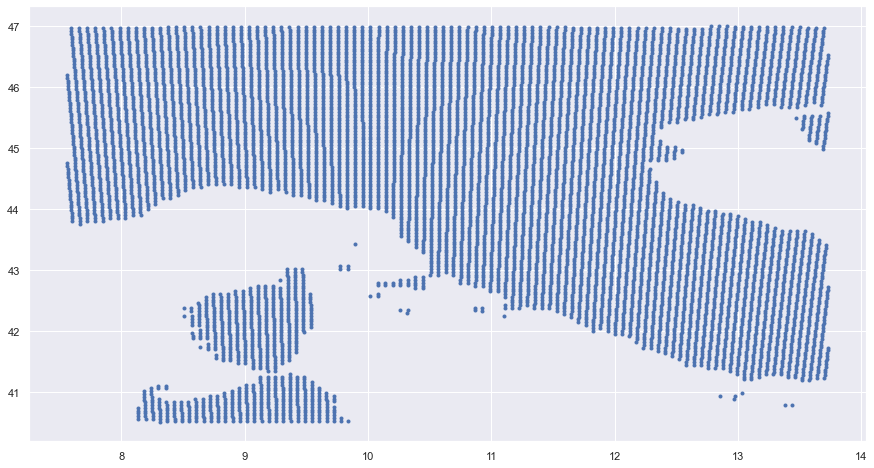

In [32]:
df_coordinates = df[df['discharge'] != 0]
df_coordinates = df.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
df_coordinates = df_coordinates.aggregate(aggregation_functions)

print('-'*40)
print(df_coordinates.head())
print('-'*40)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.')

First of all, we need to filter North Italy coordinates only on river locations based on a proximity pattern matching where we assign the measurement of discharge to the nearest river. We filterd in the matching_points notebooks these points. So, we can associate each value with the filtered one.

In [33]:
# set the coordinates as index of the dataframe
df_drop = df.drop(columns = ['time', 'discharge', 'temp', 'prec'], inplace=False)
df['coords'] = df_drop.apply(tuple, axis=1)
df = df.set_index(['coords', 'time'])
df.tail()

lat        lon discharge  \
coords                time                                                 
(41.23425, 13.701608) 2019-12-27 12:00:00  41.23425  13.701608  1.253906   
                      2019-12-28 12:00:00  41.23425  13.701608  1.119141   
                      2019-12-29 12:00:00  41.23425  13.701608  0.998535   
                      2019-12-30 12:00:00  41.23425  13.701608  0.892578   
                      2019-12-31 12:00:00  41.23425  13.701608   0.80127   

                                               temp     prec  
coords                time                                    
(41.23425, 13.701608) 2019-12-27 12:00:00  9.257745      0.0  
                      2019-12-28 12:00:00  6.976892      0.0  
                      2019-12-29 12:00:00  9.014337      0.0  
                      2019-12-30 12:00:00  9.458612  0.00001  
                      2019-12-31 12:00:00  9.968561      0.0

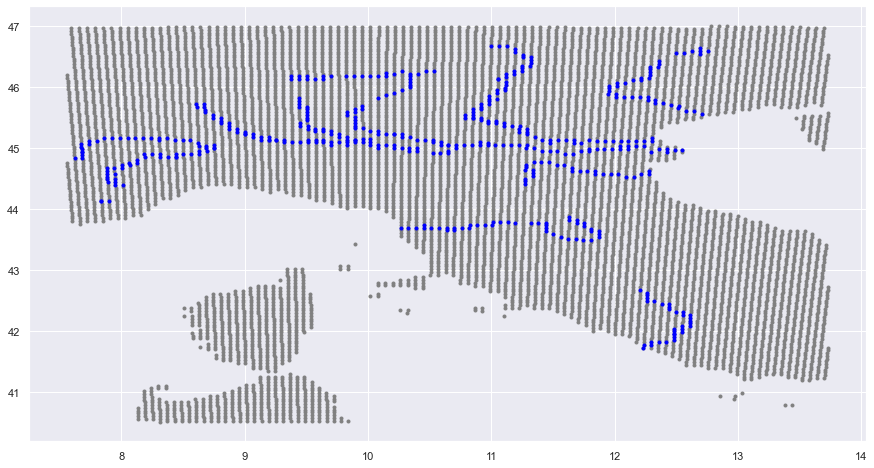

In [34]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])

# plot coordinates
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(longs, lats, '.', color='blue')



The previous plot shows the interested data from the original dataset related to river discharge measurements. Actually, our dataframe contains the total amount of coordinates of the North Italy, so we need to delete coordinates by index using a patter matching between the pair of river coordinates with dataframe indices. 

In [35]:
coords_tuple = []
for i in range(len(lats)):
    coords_tuple.append(tuple([lats[i], longs[i]]))
coords_tuple[:10]

[(44.841927, 7.6197023),
 (45.068577, 7.673447),
 (45.023533, 7.6753263),
 (44.97849, 7.677202),
 (44.93344, 7.679074),
 (44.93344, 7.679074),
 (44.888393, 7.680941),
 (44.843346, 7.682805),
 (45.115005, 7.734975),
 (45.06996, 7.736807)]

In [36]:
rivers = pd.DataFrame()
rivers = data[data['coords'].isin(coords_tuple)]

In [37]:
rivers.head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


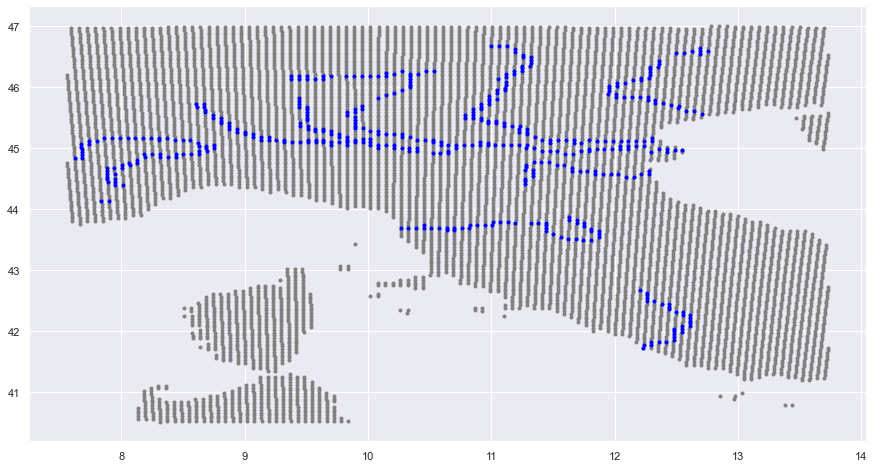

In [38]:
coords_rivers = rivers.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
coords_rivers = coords_rivers.aggregate(aggregation_functions)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

In [39]:
coords_rivers.head()

,lat,lon,discharge,temp,time,prec
0,41.730213,12.233403,217.905603,16.373907,2011-01-01 12:00:00,0.000021
1,41.774025,12.294938,217.534538,16.323665,2011-01-01 12:00:00,0.000021
2,41.77538,12.235047,0.408188,16.272904,2011-01-01 12:00:00,0.000020
3,41.81637,12.416491,214.655165,16.466457,2011-01-01 12:00:00,0.000023
4,41.817795,12.356562,216.510760,16.344858,2011-01-01 12:00:00,0.000022


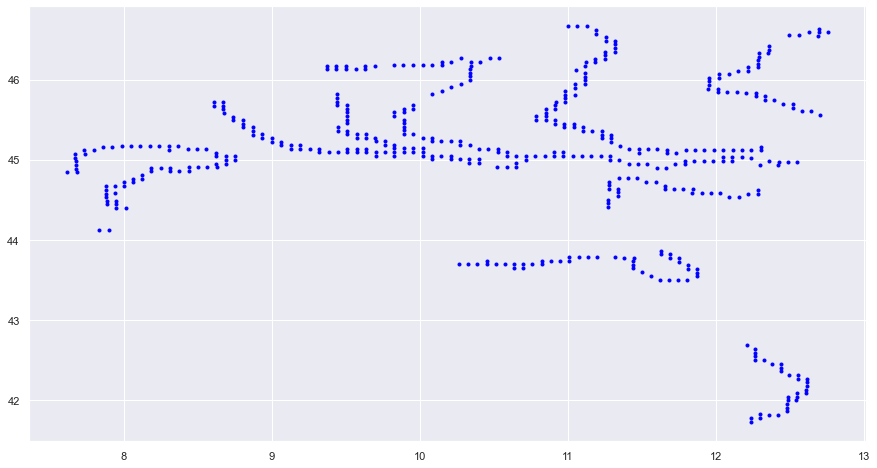

In [40]:
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

The last plot shows the difference in the locations stored in the final dataset. So, we can already use data to analyze their correlation with features and past values over time. We will analyze autocorrelation and feature correlations using different statistical tests to accept or refuse our different hypotheses on data observations. Then we can make some conclusions that may help for the modeling phase.

## Data Correlations

This section shows some statistical analysis that can retrieve important information about the behavior of time series related to one or more features. According to our analysis, we need to consider only river locations and ignore the approximation given by coordinates that do not hit the river surface (approximately in the distance greater than 2.5 km).

In [41]:
rivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518594 entries, 18980 to 2719979
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   time       1518594 non-null  object
 1   lat        1518594 non-null  object
 2   lon        1518594 non-null  object
 3   discharge  1518594 non-null  object
 4   temp       1518594 non-null  object
 5   prec       1518594 non-null  object
 6   coords     1518594 non-null  object
dtypes: object(7)
memory usage: 92.7+ MB


Rivers dataset has 6 columns with non-null representations. It consists in different time series filtered by geographical location given by latitude and longitude values combinations. Discharges, temperatures and precipitations changes over time for a same location and gives a time series visualization. The latitude and longitude are duplicated in 3 different columns: 2 for single values and 1 with a pair.

In [42]:
print('Total Points: {}'.format(rivers['coords'].nunique()))
coordinates = list(set(rivers['coords'])) # we take each coordinates 1 time.

Total Points: 462


According to the previous output, we have 481 different unique points with a related time series for discharge, temperature and precipitation fields.

In [43]:
rivers['time']

18980      2011-01-01 12:00:00
18981      2011-01-02 12:00:00
18982      2011-01-03 12:00:00
18983      2011-01-04 12:00:00
18984      2011-01-05 12:00:00
                  ...         
2719975    2019-12-27 12:00:00
2719976    2019-12-28 12:00:00
2719977    2019-12-29 12:00:00
2719978    2019-12-30 12:00:00
2719979    2019-12-31 12:00:00
Name: time, Length: 1518594, dtype: object

We prepare data for splitting in time and locations. We already add a column related to the combination to latitude and longitude in an unique value. So, we let only split the time. In our case, time series is already daily because every measurement is done only 1 time per day at 12:00 a.m. and we can divide the $datetime$ only on days, months and years.

In [44]:
rivers.head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


In [45]:
coordinates[:10]

[(45.225395, 9.065623),
 (44.950962, 8.690675),
 (45.22481, 9.002067),
 (42.084316, 12.547628),
 (44.578274, 7.9451356),
 (45.124073, 11.7957),
 (45.0442, 11.032715),
 (44.627335, 11.842756),
 (42.497784, 12.261804),
 (44.622078, 7.880634)]

In [46]:
# Po river on the source side
source_po = rivers[rivers['coords'] == (44.841927, 7.6197023)]
source_po = source_po.drop(columns=['lat', 'lon', 'coords'])

# Po river on the outfall
outfall_po = rivers[rivers['coords'] ==  (44.97764, 12.360751)]
outfall_po = outfall_po.drop(columns=['lat', 'lon', 'coords'])

print('Source Po:')
print("-"*60)
print(source_po.head())
print("-"*60)
print('Outfall Po:')
print(outfall_po.head())


Source Po:
------------------------------------------------------------
                      time  discharge      temp      prec
18980  2011-01-01 12:00:00   58.29492   5.29165       0.0
18981  2011-01-02 12:00:00  56.325195  4.353876  0.000002
18982  2011-01-03 12:00:00  54.467773  5.771906  0.000001
18983  2011-01-04 12:00:00  52.753906  8.080682       0.0
18984  2011-01-05 12:00:00  51.195312  6.497247       0.0
------------------------------------------------------------
Outfall Po:
                        time  discharge      temp      prec
2497330  2011-01-01 12:00:00  1917.3906  7.559625   0.00005
2497331  2011-01-02 12:00:00  1743.9287  8.169244  0.000243
2497332  2011-01-03 12:00:00  1610.3262  7.101831  0.000044
2497333  2011-01-04 12:00:00  1504.0117  8.676447  0.000011
2497334  2011-01-05 12:00:00  1410.6719   5.42074       0.0


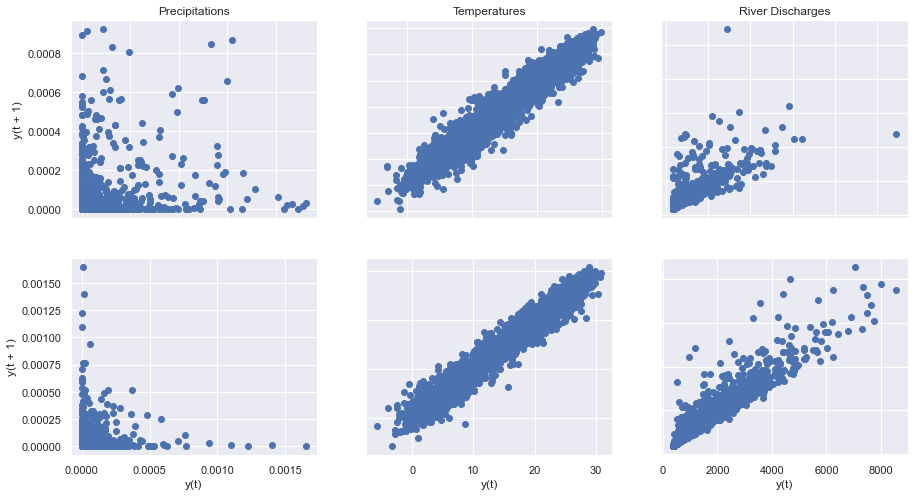

In [47]:
fig, axs = plt.subplots(2, 3)
lag_plot(source_po['prec'], ax=axs[0,0])
axs[0, 0].set_title('Precipitations')

lag_plot(source_po['temp'], ax=axs[0,1])
axs[0, 1].set_title('Temperatures')

lag_plot(source_po['discharge'], ax=axs[0,2])
axs[0, 2].set_title('River Discharges')


lag_plot(outfall_po['prec'], ax=axs[1,0])
axs[0, 0].set_title('Precipitations')

lag_plot(outfall_po['temp'], ax=axs[1,1])
axs[0, 1].set_title('Temperatures')

lag_plot(outfall_po['discharge'], ax=axs[1,2])
axs[0, 2].set_title('River Discharges')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

The lag plot can show if there is some autocorrelation related to the linearity of the distribution. Images belove show positive linear trends for temperature and discharge, and this should be an observation related to positive autocorrelations for these features. Meanwhile, precipitations have a significant amount of outliers, and it is not even linear, so it does not present any autocorrelation.

## Augmented Dickey-Fuller Tests

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series. So, we can use it to test the stationary for the temperatures, precipitations and discharges on the selected samples.

In [48]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary

print('ADF on River Discharges:')
DIS = np.array(source_po['discharge'])
result = adfuller(DIS)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Precipitations:')
PREC = np.array(source_po['prec'])
result = adfuller(PREC)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Air Temperatures:')
TEMP = np.array(source_po['temp'])
result = adfuller(TEMP)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF on River Discharges:
ADF Statistic: -8.302082743969079
p-value: 3.9932422349932996e-13
H0 rejected: It is stationary
Critical Values:
	1%: -3.4323470795742725
	5%: -2.8624223911394444
	10%: -2.5672397153452704
----------------------------------------
ADF on Precipitations:
ADF Statistic: -42.74859229328238
p-value: 0.0
H0 rejected: It is stationary
Critical Values:
	1%: -3.4323416055066382
	5%: -2.86241997328205
	10%: -2.5672384281310743
----------------------------------------
ADF on Air Temperatures:
ADF Statistic: -3.464986848000463
p-value: 0.008933176686532518
H0 rejected: It is stationary
Critical Values:
	1%: -3.432348910956668
	5%: -2.8624232000472514
	10%: -2.5672401459901955


In [49]:
print('ADF on River Discharges:')
DIS2 = np.array(outfall_po['discharge'])
result = adfuller(DIS)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Precipitations:')
PREC2 = np.array(outfall_po['prec'])
result = adfuller(PREC)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

print('-'*40)
print('ADF on Air Temperatures:')
TEMP2 = np.array(outfall_po['temp'])
result = adfuller(TEMP)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
if result[1] < 0.05:
    print('H0 rejected: It is stationary')
else:
    print('H0 accepted: It is not stationary')
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF on River Discharges:
ADF Statistic: -8.302082743969079
p-value: 3.9932422349932996e-13
H0 rejected: It is stationary
Critical Values:
	1%: -3.4323470795742725
	5%: -2.8624223911394444
	10%: -2.5672397153452704
----------------------------------------
ADF on Precipitations:
ADF Statistic: -42.74859229328238
p-value: 0.0
H0 rejected: It is stationary
Critical Values:
	1%: -3.4323416055066382
	5%: -2.86241997328205
	10%: -2.5672384281310743
----------------------------------------
ADF on Air Temperatures:
ADF Statistic: -3.464986848000463
p-value: 0.008933176686532518
H0 rejected: It is stationary
Critical Values:
	1%: -3.432348910956668
	5%: -2.8624232000472514
	10%: -2.5672401459901955


ADF is a significant test based on Unit Root categories. The ADf expands the Dickey-Fuller Test including high order regressive process in the model. 

$ y_t = c + \beta t + \alpha y_{t-1} + \Theta_{1} \Lambda Y_{t-1} + \Theta_{2} \Lambda Y_{t-2}...+ \Theta_{p} \Lambda Y_{t-p} + e_t$ ; $ p \in [1..t] $ 

The Dickey-Fuller test has a null hypothesis of the existence of the unit root that can make the time series not stationary, which is equal to that $ \alpha = 1 $ in the previous equation. 

## KPSS Test 

Alternatively to the Augmented Dickey-Fuller test, the KPSS Test has a null hypothesis that confirms the stationary. So, we should reject the null hypothesis and accept the alternative one to determine the correct observation.

In [50]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

print('Source of Po:')
print('Discharge River KPSS:\n{}'.format(kpss_test(DIS)))
print('Air Temperature KPSS:\n{}'.format(kpss_test(TEMP)))
print('Precipitations KPSS:\n{}'.format(kpss_test(PREC)))

Source of Po:
KPSS Statistic: 0.6249608178481902
p-value: 0.020367198377437248
num lags: 34
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary
Discharge River KPSS:
None
KPSS Statistic: 0.07627372249303115
p-value: 0.1
num lags: 36
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Air Temperature KPSS:
None
KPSS Statistic: 0.08555647146040779
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Precipitations KPSS:
None


In [51]:
print('Ovefall of Po:')
print('Discharge River KPSS:\n{}'.format(kpss_test(DIS2)))
print('Air Temperature KPSS:\n{}'.format(kpss_test(outfall_po['temp'].diff().dropna())))
print('Precipitations KPSS:\n{}'.format(kpss_test(PREC2)))

Ovefall of Po:
KPSS Statistic: 0.3025661959148959
p-value: 0.1
num lags: 34
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Discharge River KPSS:
None
KPSS Statistic: 0.03335310310204365
p-value: 0.1
num lags: 49
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Air Temperature KPSS:
None
KPSS Statistic: 0.09390294579773587
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
Precipitations KPSS:
None


We verified that each time series is stationary in a long-term analysis. This observation should help during the modelling phase for the model selection. 

## Granger Causality

In [65]:
# training and validation splitting 
data = source_po.set_index('time')
data2 = outfall_po.set_index('time')

In [66]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 19
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=True):    
    """Application of the Granger Causality test on data using filtered parameters given
    by the columns of the input dataframe. This function return the confusion matrix about the 
    causality relations between x and y where x (cols) causes y (rows).

    Args:
        data (pd.DataFrame): input dataframe
        variables (np.Array): array of variables related to the time series of the granger causality testing
        test (str, optional): Type of test related to the granger causality, values are internal of fixed values (ssr_ftest, ssr_chi2test, params_ftest, lrtest)
        verbose (bool, optional): Verbose mode. Defaults to False.

    Returns:
        pd.DataFrame: It is a fixed DataFrame from pandas library where the current
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [67]:
print('Granger causality on chi2test:\n{}\n'.format(grangers_causation_matrix(data, variables = data.columns, verbose=False)))
print('Granger causality on lrtest:\n{}\n'.format(grangers_causation_matrix(data, variables = data.columns, test='lrtest', verbose=False)))
print('Granger causality on ssr_ftest:\n{}\n'.format(grangers_causation_matrix(data, variables = data.columns, test='ssr_ftest', verbose=False)))

Granger causality on chi2test:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.2805  0.0863
temp_y            0.0122  1.0000  0.0000
prec_y            0.0018  0.0608  1.0000

Granger causality on lrtest:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.2806  0.0864
temp_y            0.0128  1.0000  0.0000
prec_y            0.0019  0.0609  1.0000

Granger causality on ssr_ftest:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.2808  0.0865
temp_y            0.0139  1.0000  0.0000
prec_y            0.0020  0.0610  1.0000



In [68]:
print('Granger causality on chi2test:\n{}\n'.format(grangers_causation_matrix(data2, variables = data2.columns, verbose=False)))
print('Granger causality on lrtest:\n{}\n'.format(grangers_causation_matrix(data2, variables = data2.columns, test='lrtest', verbose=False)))
print('Granger causality on ssr_ftest:\n{}\n'.format(grangers_causation_matrix(data2, variables = data2.columns, test='ssr_ftest', verbose=False)))

Granger causality on chi2test:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.4889  0.0423
temp_y            0.0246  1.0000  0.0283
prec_y            0.2099  0.4473  1.0000

Granger causality on lrtest:
             discharge_x  temp_x  prec_x
discharge_y        1.000  0.4889  0.0436
temp_y             0.025  1.0000  0.0285
prec_y             0.210  0.4474  1.0000

Granger causality on ssr_ftest:
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.4891  0.0461
temp_y            0.0258  1.0000  0.0287
prec_y            0.2102  0.4479  1.0000

